# Exploring Practical Recommendation Systems In Neo4j
### __An Example With Collaborative Leveraging Graph Data Science and Machgine Learning__

In this notebook we explore how to get started with practical & scalable recommendation in graph. We will walk through a fundamental example with news recommendation on dataset containing 17.5 Million click events and around 750K users. We will leverage Neo4j and the Graph Data Science (GDS) library to quickly predict similar news based on user preferences and enable sub-second, rank-ordered, recommendation queries personalized to each user.

This notebook is structured as follows: 

1. setup some configurations and helper functions to allow us to work with the graph. 
2. Go over the source dataset and graph we will be using along with how to query basic profiling statistics to help us understand the graph and better prepare for analysis. 
3. Briefly introduce a technique called Collaborative filtering (CF) which will be our mechanism for recommendation in this notebook
4. Explore Applying the Cypher query language for basic CF
5. Scaling CF with the Graph Data Science (GDS) Library, leveraging Node embeddings and an ML technique called K-Nearest Neighbor (KNN).

## Notebook Setup

In [1]:
from graphdatascience import GraphDataScience
import pandas as pd
import numpy as np
import configparser
import os
import matplotlib.pyplot as plt
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 12)

### Neo4j Settings
The `NEO4J_PROPERTIES_FILE` is an ini configuration file for Neo4j properties so this notebook can connect to
your Neo4j instance and load data. The ini file should be formatted as follows
```
[NEO4J]
PASSWORD=<password>
USERNAME=<database name, is 'neo4j' by default>
HOST=<host uri>

```

Set `NEO4J_PROPERTIES_FILE` to None or any non-existent location to use the below defaults
```
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'
```

In [2]:
NEO4J_PROPERTIES_FILE = '/Users/zachblumenfeld/devtools/aura-mind-2.ini'

In [3]:
## Using an ini file for credentials, otherwise providing defaults
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'

if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_PROPERTIES_FILE)
    HOST = config['NEO4J']['HOST']
    USERNAME = config['NEO4J']['USERNAME']
    PASSWORD = config['NEO4J']['PASSWORD']
    print('Using custom database properties')
else:
    print('Could not find database properties file, using defaults')

Using custom database properties


In [4]:
gds = GraphDataScience(HOST, auth=(USERNAME, PASSWORD), aura_ds=True)

### Helper Functions

In [5]:
class GraphQueryError(Exception):
    def __init__(self, message):
        self.message = message


def run(driver, query, params=None):
    with driver.session() as session:
        if params is not None:
            return [r for r in session.run(query, params)]
        else:
            return [r for r in session.run(query)]

def degree_counts(node_label, relationship_type, direction='BOTH'):
    dr = direction.upper()
    if dr not in {'BOTH', 'IN', 'OUT'}:
        raise GraphQueryError(f"direction must be one of {{'BOTH', 'IN', 'OUT'}}, but got {dr}")

    pattern = f'(n)<-[:{relationship_type}]-()'
    if dr == 'BOTH':
        pattern = f'(n)-[:{relationship_type}]-()'
    elif dr == 'OUT':
        pattern = f'(n)-[:{relationship_type}]->()'

    df= gds.run_cypher( f'''
            MATCH (n:{node_label}) WITH id(n) as nodeIds, size({pattern}) AS degree
            RETURN degree, count(degree) AS degreeCount ORDER BY degree
        ''')

    df['csum'] = df.degreeCount.cumsum()
    n = df.degreeCount.sum()
    df['percentile'] = df.csum/n
    return df.drop(columns=['csum'])

def get_percentiles(df, q=None):
    if q is None:
        q = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_name = ['min'] + [f'p{int(100*i)}' for i in q] + ['max']
    p = [df.degree.min()] + [df.degree[df.percentile >= i].iloc[0] for i in q] + [df.degree.max()]
    p_df = pd.DataFrame(np.column_stack((q_name, p)), columns=['q', 'percentile'])
    return p_df.set_index('q')

## Dataset: Microsoft MIND

We will explore news recommendation with the [__MI__crosoft __N__ews __D__ataset (MIND) Large Dataset](https://msnews.github.io/) which is a sample of 1 million anonymized users and their click behaviors collected from the Microsoft News website \[1\]. It includes about 15M impressions logs for about 160K English News articles.
I formatted the dataset and loaded into a graph with the below schema:

\[1\]: Fangzhao Wu, Ying Qiao, Jiun-Hung Chen, Chuhan Wu, Tao Qi, Jianxun Lian, Danyang Liu, Xing Xie, Jianfeng Gao, Winnie Wu and Ming Zhou. MIND: A Large-scale Dataset for News Recommendation. ACL 2020.

```
//visualize schema in Neo4j Browser
neo4j$ CALL db.schema.visualization();
```
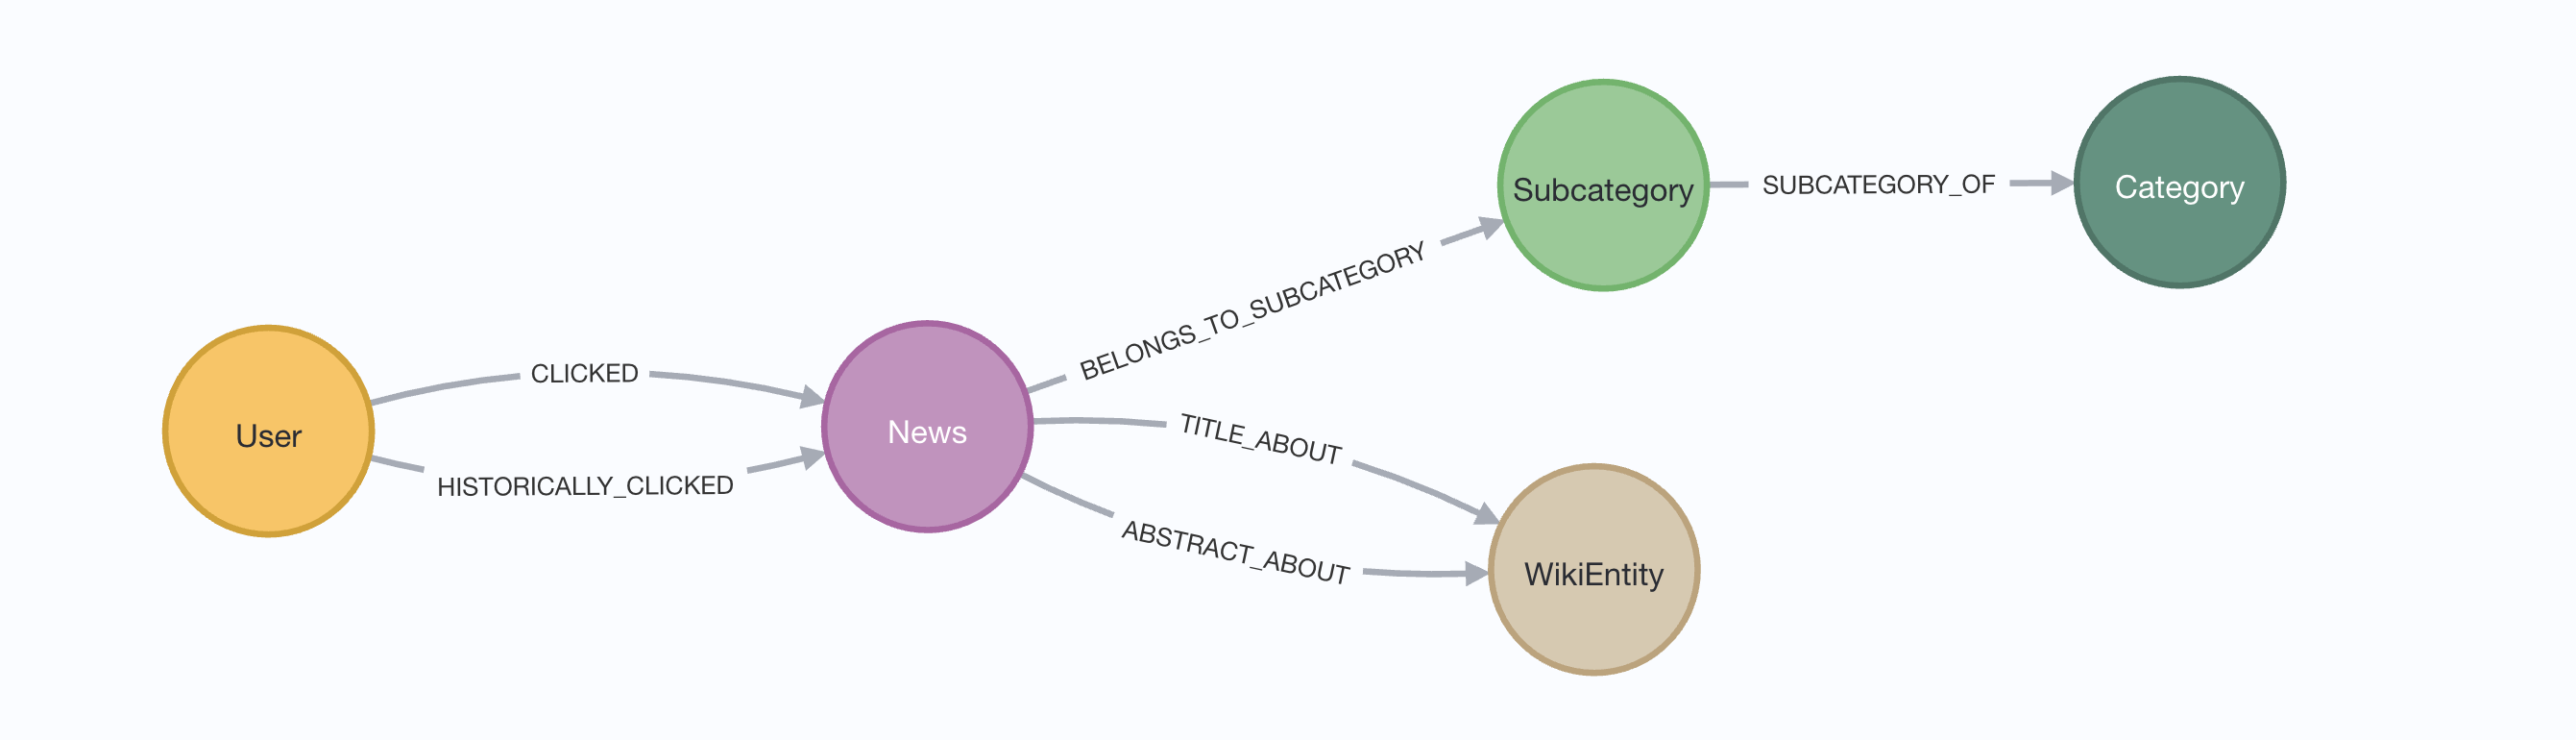

We see that news articles are modeled as nodes and can can be "clicked" or "historically clicked" by users which are also modeled as nodes. In this context, "clicked" refers to a click action parsed from an impression record occurring over the time interval of our sample, approx. 2019 November 9th through 2019 November 15th. "historically clicked" refers to a click action from user history, occurring in some unknown time in the past.

Additionally, News also have subcategories and categories that were annotated by Microsoft as well as WikiData entities that Microsoft extracted from news titles and abstracts using NLP methods. I modeled these with nodes and relationships in the graph as well. These will be useful for extended analysis, but we will not be using them in this example. Our primary interest here is to get started with users and their click events to derive recommendations.

### Graph Data Profiling
Before diving right into into analysis, it is helpful to inspect some high level statistics of graph to get a better sense of size and connectivity.

#### Aggregate Counts
Let's start with high node and relationships counts. These functions assume [APOC](https://neo4j.com/developer/neo4j-apoc/) is installed on your Neo4j DB.

In [6]:
# total node counts
gds.run_cypher( '''
    CALL apoc.meta.stats()
    YIELD labels AS nodeCounts
    UNWIND keys(nodeCounts) AS label
    WITH label, nodeCounts[label] AS nodeCount
    WHERE label IN ['User','News']
    RETURN label, nodeCount
''')

,label,nodeCount
0,User,750434
1,News,104151


In [7]:
# total relationship counts
gds.run_cypher( '''
    CALL apoc.meta.stats()
    YIELD relTypesCount as relationshipCounts
    UNWIND keys(relationshipCounts) AS type
    WITH type, relationshipCounts[type] AS relationshipCount
    WHERE type IN ['CLICKED','HISTORICALLY_CLICKED']
    RETURN type, relationshipCount
''')

,type,relationshipCount
0,CLICKED,3958501
1,HISTORICALLY_CLICKED,13580648


As far as search recommendation is concerns this is a relatively modestly sized graph, with only around 750K users, 100k news articles, and around 17.5 M total click events. These numbers are smaller than the totals reported for MIND Large because some of the original dataset was set aside by Microsoft as a test set for competition evaluation and therefore doesn't have complete impression information. That part of the data was excluded from this graph.

#### Click Event Distributions
Next, we can look at the distribution of clicks per user. It is helpful to check this distribution to make sure that:
1. The graph is reasonably well connected as the quality of our upcoming recommendation technique will depend on a reasonably well connected graph.
2. We do not have any large [supernodes](https://medium.com/neo4j/graph-modeling-all-about-super-nodes-d6ad7e11015b), i.e. nodes with very high numbers of relationships. What qualifies as a supernode varies greatly by use case. For this, I would be concerned about users with tens of thousands of clicks.

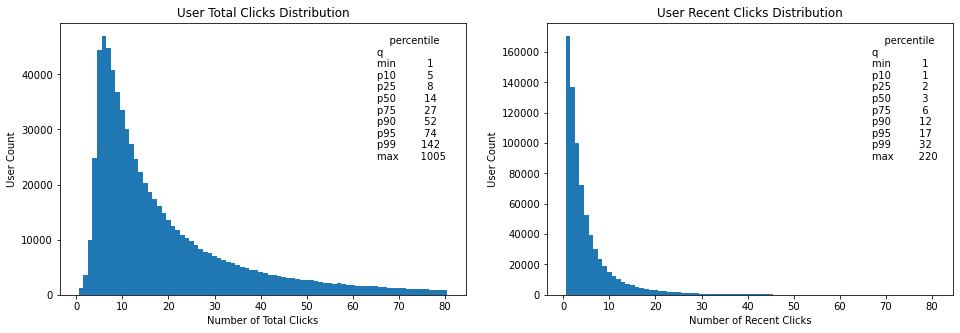

In [8]:
all_clicks_df = degree_counts( 'User', 'CLICKED|HISTORICALLY_CLICKED', 'OUT')
recent_clicks_df = degree_counts('User', 'CLICKED', 'OUT')

f, axs = plt.subplots(1,2,figsize=(16,5))

axs[0].bar(all_clicks_df.degree[:80], all_clicks_df.degreeCount[:80], width=1)
axs[0].set_title('User Total Clicks Distribution')
axs[0].set_ylabel('User Count')
axs[0].set_xlabel('Number of Total Clicks')
plt.figtext(0.4, 0.5, get_percentiles(all_clicks_df).to_string())


axs[1].bar(recent_clicks_df.degree[:80], recent_clicks_df.degreeCount[:80], width=1)
axs[1].set_title('User Recent Clicks Distribution')
axs[1].set_ylabel('User Count')
axs[1].set_xlabel('Number of Recent Clicks')
plt.figtext(0.83, 0.5, get_percentiles(recent_clicks_df).to_string())

plt.show()

The above shows the distributions for total clicks (`CLICKED` and `HISTORICALLY_CLICKED`) as well as recent clicks (just `CLICKED`) by user. We see that the distributions have heavy left tails, showing that activity is not uniformly distributed among users, but rather there is relatively small fraction of users that account for a large number of clicks. This is somewhat expected. Importantly every user has at least one recent click event, and we do not see users with upwards of tens of thousands of click events.

We can do a similar breakdown for News below.

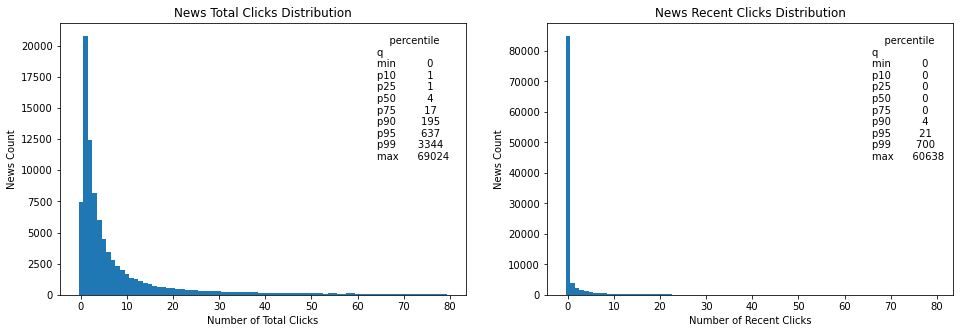

In [9]:
all_clicks_df = degree_counts('News', 'CLICKED|HISTORICALLY_CLICKED', 'IN')
recent_clicks_df = degree_counts('News', 'CLICKED', 'IN')

f, axs = plt.subplots(1,2,figsize=(16,5))

axs[0].bar(all_clicks_df.degree[:80], all_clicks_df.degreeCount[:80], width=1)
axs[0].set_title('News Total Clicks Distribution')
axs[0].set_ylabel('News Count')
axs[0].set_xlabel('Number of Total Clicks')
plt.figtext(0.4, 0.5, get_percentiles(all_clicks_df).to_string())


axs[1].bar(recent_clicks_df.degree[:80], recent_clicks_df.degreeCount[:80], width=1)
axs[1].set_title('News Recent Clicks Distribution')
axs[1].set_ylabel('News Count')
axs[1].set_xlabel('Number of Recent Clicks')
plt.figtext(0.83, 0.5, get_percentiles(recent_clicks_df).to_string())

plt.show()

While news looks okay for total clicks, only a small portion of news (<25%) was recently clicked, i.e. actually clicked on by users in the time window of our sample. News that was not clicked within the time window may not be good candidates for recommendation in this context. We will deal with this below.

### Labeling Recent News

To ensure CF recommendations are relevant we need to filter down to a subset of news articles for consideration.

1. News tends to be most relevant when it is recent and can lose relevance quickly with the passage of time. As general rule, __good news recommenders should avoid stale and/or outdated news__. In this case we can use Microsoft impressions as a proxy and __only consider news articles that were included in an impression within our sample time window__. To accomplish this, we can use a node attribute called `approxTime`, that reflects the minimum impression time for the news article. I calculated this attribute when loading the source data into Neo4j. Long story short, `approxTime` will only be non-null for news articles with at least one impression in our sample.

2. A limitation of CF is that it can only recommend content with user feedback. As such, __news articles with no user clicks cannot be used for CF here__. In industry, this is sometimes referred to as a [cold-start](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)) problem. It can be resolved with content based recommendation and other hybrid approaches. We may cover this in a separate post, but for this example we only consider news articles with at least one user clicks, i.e. at least one `CLICKED` or `HISTORICALLY_CLICKED` relationship.

We can assign a second node label, `RecentNews` to allow us to easily filter to news that meet the above criteria in cypher queries and GDS projections. Remember that Neo4j allows a node to have multiple labels, so the original News label will still be retained.

In [10]:
gds.run_cypher('''
    MATCH(n:News)<-[:CLICKED|HISTORICALLY_CLICKED]-() WHERE n.approxTime IS NOT NULL
    SET n:RecentNews
    RETURN count(DISTINCT n)
    ''')

,count(DISTINCT n)
0,21858


We do see a significant reduction in the number of News Articles, from 104K to about 22K. But being more recent and well connected, this news is also likely to be more relevant, so we should be able to improve our recommender by narrowing the focus to these news articles. We can also see these improvements reflected in the click distributions.

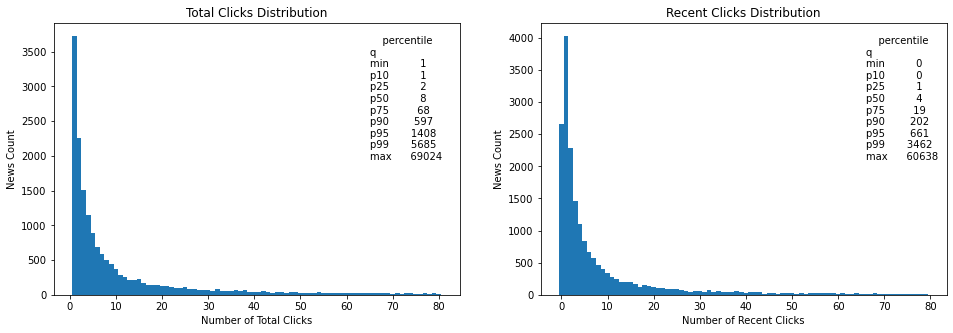

In [11]:
all_clicks_df = degree_counts('RecentNews', 'CLICKED|HISTORICALLY_CLICKED', 'IN')
recent_clicks_df = degree_counts('RecentNews', 'CLICKED', 'IN')

f, axs = plt.subplots(1,2,figsize=(16,5))

axs[0].bar(all_clicks_df.degree[:80], all_clicks_df.degreeCount[:80], width=1)
axs[0].set_title('Total Clicks Distribution')
axs[0].set_ylabel('News Count')
axs[0].set_xlabel('Number of Total Clicks')
plt.figtext(0.4, 0.5, get_percentiles(all_clicks_df).to_string())


axs[1].bar(recent_clicks_df.degree[:80], recent_clicks_df.degreeCount[:80], width=1)
axs[1].set_title('Recent Clicks Distribution')
axs[1].set_ylabel('News Count')
axs[1].set_xlabel('Number of Recent Clicks')
plt.figtext(0.83, 0.5, get_percentiles(recent_clicks_df).to_string())

plt.show()

We can see now that every news article was clicked at least once, and at least 75% of the news articles have been recently clicked. 

## Collaborative Filtering (CF)

There are many different types of recommendations systems. In this example we will apply a technique called Collaborative Filtering (CF), which is the practice of automatically predicting a user's preferences based on the actions of similar users.

### User vs Item Based CF
Roughly speaking there are two main classes of collaborative filtering
1. User-based, which is focuses on directly calculating similarity between users based on their interaction with items
2. Item-based, which measures the similarity between pairs of items based on correlated user activity, such as the same users liking, viewing, rating, or otherwise similarly interacting with items

Our approach today will focus on the later, item-based CF. Item-based CF will be more manageable and scalable then user-based CF for many problem domains. There are a couple reasons for this. First, because there are way fewer items then users in most applied cases so there are less entities to compare. Second, and perhaps more importantly, User preferences can also be dynamic and change overtime. For example, in a Movie example, a user could be mostly interested in Sci Fi movies but go through a brief stint in Westerns, and making recommendations for Westerns to other Sci Fi fans who historically viewed the same things may not be the best thing. Often the best indicator of a user's current interest is their most recent activity, and item based filtering gives you better flexibility to find similarities based off the most recent item(s) clicked, viewed, rated, etc.

### Implicit Collaborative Filtering
You will usually hear about collaborative filtering in the context of explicit user feedback such as reviews for movies or products in an online store. In this example, we will apply collaborative filtering to just the News click activity, i.e. 1 for a click, implying that the user "likes" a piece of content and 0 otherwise. This is a basic form of "implicit collaborative filtering"  where a users preferences are implied based on their activity rather than in explicit feedback. The need for implicit CF comes up frequently as many real-world scenarios will not have explicit ratings, or if they do they will very sparsely populated. In a production setting, you may also want to incorporate other user activity data points to help weight the graph relationships such as read/view time, scroll-depth, etc. which are not publically made available in the MIND dataset. The more information you have, the more accurately you will be able to model user preferences.

## Basic Cypher Queries for CF
From here we could try just using Cypher to accomplish basic Collaborative Filtering. For example, take the below user and the news they clicked. You can see a mixed interest between autos, finance, US news, and a couple other categories.

In [12]:
USER_ID = "U218584" 

In [13]:
gds.run_cypher('''
    MATCH (u1:User {userId: $userId})
           -[r1:CLICKED|HISTORICALLY_CLICKED]->(n1:RecentNews)
    RETURN n1.newsId AS newsId,
           n1.title AS title,
           n1.abstract AS abstract,
           n1.category AS category,
           n1.subcategory As subcategory,
           r1.impressionTime AS impressionTime,
           type(r1) AS clickType
    ORDER BY clickType, impressionTime DESC
    ''', params={'userId': USER_ID})


,newsId,title,abstract,category,subcategory,impressionTime,clickType
0,N110709,2020 Ford Mustang Shelby GT350 vs. GT500: Which Is the Better Sports Car?,"Is the $12,460 more costly GT500 a better sports car than the already great GT350?",autos,autosenthusiasts,2019-11-15T05:48:40.000000000+00:00,CLICKED
1,N29544,"Walmart releases Black Friday ad with $129 Apple Watch, TV deals, electronics doorbusters","Walmart's Black Friday 2019 ad includes a 40-inch TV for $98, Apple iPad for $249, Xbox One, Playstation 4, deals on toys, Instant Pot and more.",finance,finance-companies,2019-11-14T08:39:30.000000000+00:00,CLICKED
2,N30899,College gymnast dies following training accident in Connecticut,"Melanie Coleman, 20, of Milford, was practicing on the bars when she suffered a spinal cord injury.",news,newsus,2019-11-12T08:39:20.000000000+00:00,CLICKED
3,N83412,Hannah Brown on Being Surrounded By Exes Tyler Cameron and Colton Underwood,ET spoke with the former Bachelorette after 'Dancing With the Stars' on Monday.,tv,tv-celebrity,2019-11-12T05:53:44.000000000+00:00,CLICKED
4,N60088,2020 Ford Bronco: Everything we know about Ford's new SUV,It's only a matter of time until Ford pulls back the veil.,autos,autossuvs,2019-11-11T10:10:49.000000000+00:00,CLICKED
5,N64797,Off-Road Diesel Truck Showdown: GMC Sierra 1500 AT4 vs. Ram 1500 Rebel,Does GMC or Ram build the best jack-of-all-trades pickup?,autos,autostrucks,2019-11-11T10:10:49.000000000+00:00,CLICKED
6,N86208,17 photos that show the ugly truth of living in a tiny house,"From cramped lofts that are hard to access to small appliances, this is what it's really like to live in a tiny house.",lifestyle,lifestylehomeandgarden,None,HISTORICALLY_CLICKED
7,N59565,"10 Exercises You Should Never Do Again, According to Trainers",Newsflash: Some moves (and exercise machines) don't actually do that much for you and some can be downright dangerous.,health,fitness,None,HISTORICALLY_CLICKED
8,N108707,Rivian R1S and R1T: Everything We Know,"The Plymouth, Michigan startup quickly became one of the hottest things in the automotive world. Here's what to expect from its first two cars.",autos,autosnews,None,HISTORICALLY_CLICKED


Assuming we can measure the similarity of user interests via commonly clicked news articles, we can do a three hop query to find potential recommendations for user `U218584` based on the activity of users that clicked on the same news as `U218584`.

With the below query we can get an aggregate count of the nodes we would need to traverse over to get the recommendations. To keep things simple we won't worry about historic clicks yet.

In [14]:
gds.run_cypher('''
    MATCH (u1:User {userId: $userId})
           -[r1:CLICKED]->(n1:RecentNews)
           <-[r2:CLICKED]-(u2:User)
           -[r3:CLICKED]->(n2:RecentNews)
    RETURN u1.userId AS userId,
           count(DISTINCT n1) AS clickedNews,
           count(DISTINCT u2) AS likeUsers,
           count(DISTINCT n2) AS potentialRecommendations
    ''', params={'userId': USER_ID})

,userId,clickedNews,likeUsers,potentialRecommendations
0,U218584,6,63019,10998


While the above can work well in some cases, and while it can certainly be a massive improvement from joining SQL tables or cross-walking over document stores, notice that we get a lot of potential recommendations back (almost 11K) and must traverse over many user nodes (over 63K). And this is just a sample of the the total Microsoft dataset and we aren't leveraging historical click information at all.

For production use cases where recommendations will need to be queried frequently, this method will have trouble scaling as the number of users, amount of content, and/or observed engagement grows. We need some other strategy to help narrow down the results. There are a few different ways we can accomplish this, but one robust and scalable way to do so is with the [Neo4j Graph Data Science (GDS) Library](https://neo4j.com/docs/graph-data-science/current/).

## Scaling CF with GDS: FastRP Node Embeddings and K-Nearest-Neighbor (KNN)

With GDS we can use [FastRP node embeddings](https://neo4j.com/docs/graph-data-science/current/algorithms/fastrp/) to reduce the dimensionality of the problem then use an unsupervised machine learning technique called [K-Nearest Neighbor (KNN)](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/) to identify and draw recommendations between news with similar/close embeddings. Because FastRP embeddings are based off the graph structure, news with similar embeddings should also be relatively connected in the graph via being clicked on by the same and similar users.

### Graph Projection
We will start with a graph projection leveraging the User and News nodes. It may be helpful to include all the News in this projection for the embeddings step and filter to just the RecentNews in the KNN step. User click activity on stale news still constitutes a significant portion of the graph structure and as such may help inform similarity inferences for more recent news in the KNN step. 

We will also include both historic and recent impression clicks, but we will give less weight to historic clicks so-as to favor more recent user activity. Lastly we will use an `UNDIRECTED` orientation so FastRP can traverse the graph bi-directionaly.

In [15]:
# Putting an index on a 'weight' attribute allows us to assign default values in the projection below
gds.run_cypher('CREATE INDEX weight_index IF NOT EXISTS FOR ()-[r:CLICKED]-() ON (r.weight)')

""


In [16]:
g0, res = gds.graph.project('embedding-projection', ['User', 'News'], {
    'CLICKED':{
        'orientation':'UNDIRECTED',
        'properties': {'weight': {'property': 'confidence', 'defaultValue': 1.0}}
    },
    'HISTORICALLY_CLICKED':{
        'orientation':'UNDIRECTED',
        'properties': {'weight': {'property': 'confidence', 'defaultValue': 0.1}}
    }
})
res

nodeProjection                                                                                                                                                                                                                                                                                                                                    {'User': {'label': 'User', 'properties': {}}, 'News': {'label': 'News', 'properties': {}}}
relationshipProjection    {'CLICKED': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'CLICKED', 'properties': {'weight': {'defaultValue': 1.0, 'property': 'confidence', 'aggregation': 'DEFAULT'}}}, 'HISTORICALLY_CLICKED': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'HISTORICALLY_CLICKED', 'properties': {'weight': {'defaultValue': 0.1, 'property': 'confidence', 'aggregation': 'DEFAULT'}}}}
graphName                                                                                                                                     

### FastRP
When running FastRP we will make sure to include the relationship weight property.

In [17]:
gds.fastRP.mutate(g0, mutateProperty='embedding', embeddingDimension=256, randomSeed=7474, relationshipWeightProperty='weight');

While we should be able to do this all in one projection, depending on the GDS version you are using, I find it easiest to write the embeddings back to the database and create a seperate projection just for KNN.

In [18]:
gds.graph.writeNodeProperties(g0, ["embedding"], ["News"])

writeMillis                          2389
graphName            embedding-projection
nodeProperties                [embedding]
propertiesWritten                  104151
Name: 0, dtype: object

If you are curious this is what the embeddings look like, they are just vectors of floating point numbers. In this case they are are 256 numbers long as specified in the `embeddingDimension` parameter above.

In [19]:
gds.run_cypher('MATCH(n:RecentNews) RETURN n.newsId, n.embedding LIMIT 3')

,n.newsId,n.embedding
0,N88753,"[0.10630623251199722, 0.1723296195268631, -0.1171381026506424, -0.027835557237267494, -0.06641528010368347, 0.05011146888136864, 0.13987810909748077, -0.20932944118976593, 0.03788360580801964, 0.11861199140548706, -0.0540100634098053, -0.15462569892406464, 0.01632661372423172, 0.1190885603427887, -0.03897026181221008, 0.05449594929814339, -0.06486024707555771, -0.061245545744895935, 0.09067648649215698, 0.028144918382167816, -0.14549580216407776, 0.27434930205345154, 0.17065730690956116, 0.0..."
1,N99744,"[-0.08940580487251282, -0.08771379292011261, 0.011865541338920593, -0.10249188542366028, -0.16452103853225708, 0.067889004945755, 0.07351496815681458, -0.05297345668077469, 0.06831544637680054, -0.05956794694066048, 0.01696055568754673, -0.023166798055171967, 0.0159124955534935, 0.04748854041099548, 0.06959734112024307, 0.1891995370388031, -0.018619976937770844, -0.1406448781490326, 0.0648680329322815, 0.029595347121357918, 0.07380982488393784, 0.15983544290065765, 0.05438005551695824, 0.018..."
2,N17957,"[0.13875526189804077, -0.23850542306900024, 0.0017147976905107498, -0.07496193051338196, -0.18084552884101868, -0.014842554926872253, 0.08821369707584381, -0.13480810821056366, 0.09693685173988342, 0.058435942977666855, -0.09078291803598404, -0.1293138563632965, 0.0802997499704361, 0.04764147102832794, 0.025296352803707123, 0.1664532721042633, 0.11257122457027435, -0.06640289723873138, -0.026818327605724335, 0.1013699471950531, -0.0796460211277008, 0.13696950674057007, 0.06526796519756317, -..."


### K-Nearest-Neighbors (KNN)
We can now run KNN to estimate similarity (a.k.a. `USERS_ALSO_LIKED`) relationships between RecentNews articles and write them back to the graph.

In [20]:
g1, res = gds.graph.project('cf-projection', {'RecentNews':{'properties':['embedding']}},'*')
res

nodeProjection            {'RecentNews': {'label': 'RecentNews', 'properties': {'embedding': {'defaultValue': None, 'property': 'embedding'}}}}
relationshipProjection                         {'__ALL__': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': '*', 'properties': {}}}
graphName                                                                                                                         cf-projection
nodeCount                                                                                                                                 21858
relationshipCount                                                                                                                             0
projectMillis                                                                                                                               542
createMillis                                                                                                                            

In [21]:
knn_stats_df = gds.knn.write(g1, nodeProperties=['embedding'],
    writeRelationshipType='USERS_ALSO_LIKED',
    writeProperty='score',
    sampleRate=1.0,
    maxIterations=1000);

Below we can see statistics related to algorithm convergence, compute and write time, the number of nodes compared, pairs considered, and relationships written. KNN is actually very well optimized in GDS and uses sophisticated sampling and parallelization techniques under the hood to make it more computationally efficient and highly scalable. See the [documentation](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/) for more details if interested.

In [22]:
knn_stats_df[['didConverge',
              'ranIterations',
              'computeMillis',
              'writeMillis',
              'nodesCompared',
              'nodePairsConsidered',
              'relationshipsWritten']]

didConverge                 True
ranIterations                113
computeMillis               8216
writeMillis                 3206
nodesCompared              21858
nodePairsConsidered     41575808
relationshipsWritten      218580
Name: 0, dtype: object

KNN relationships are only written when a positive similarity is found between node pairs which, in this case, is based on [cosine similarity](https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/cosine/) between the `nodeWeightProperty` values of each node. here we are using the FastRP embedding we calculated over the click/historic click relationships as the `nodeWeightProperty`. We can see a distribution of those similarity scores below.

In [23]:
knn_stats_df.similarityDistribution

{'p1': 0.1711735725402832,
 'max': 1.000007152557373,
 'p5': 0.22878503799438477,
 'p90': 0.7270960807800293,
 'p50': 0.45824384689331055,
 'p95': 0.8772082328796387,
 'p10': 0.27173376083374023,
 'p75': 0.5613360404968262,
 'p99': 0.9319643974304199,
 'p25': 0.356687068939209,
 'p100': 1.000007152557373,
 'min': 0.10630655288696289,
 'mean': 0.47780970685686436,
 'stdDev': 0.17585065244210238}

This is a helpful distribution to check. In this case it looks reasonably healthy. If you see a lot of zeros going into higher percentiles it is a sign that KNN was not able to find many similarities. A lack of variance in your scores between percentiles can also signal a lack of variance in your node weight properties.

### Collaborative Filtering with USER_ALSO_LIKED Relationships
Now we can structure a Collaborative filtering query for user `U218584` but with
1. more refined results,
2. using less traversal steps, and
3. with a score from KNN that allows us to rank order the results based on aggregate similarity

In [24]:
gds.run_cypher( '''
    MATCH(u:User {userId: $userId})-[:CLICKED]->(n:RecentNews)
    WITH collect(id(n)) AS clickedNewsIds

    //get similar News according to KNN and exclude previously clicked news
    MATCH (clickedNews)-[s:USERS_ALSO_LIKED]->(similarNews:News)
    WHERE id(clickedNews) IN clickedNewsIds AND NOT id(similarNews) IN clickedNewsIds

    //aggregate and return ranked results
    RETURN DISTINCT similarNews.newsId as newsId, 
        similarNews.title AS title, 
        similarNews.category AS category,
        similarNews.subcategory As subcategory,
        sum(s.score) AS totalScore ORDER BY totalScore DESC
    ''', params={'userId': USER_ID})


,newsId,title,category,subcategory,totalScore
0,N71008,"Review: The 775-HP Roush Mustang is More Powerful Than a Shelby GT500, But Is It Better?",autos,autossports,1.203671
1,N81058,New Mexico game vs. Air Force rescheduled after lineman Nahje Flowers' death,sports,football_ncaa,0.778623
2,N26968,'Beautiful boys': Victims in Mexico ambush remembered at funerals,news,newsworld,0.746406
3,N107322,Reality television star Kevin O'Leary and his wife were sued Wednesday for wrongful deaths in a boat crash in Canada's backwoods.,tv,tv-celebrity,0.745013
4,N126027,Woman accused of embezzling from Camp Fire victim surrenders,news,newscrime,0.739930
...,...,...,...,...,...
54,N12922,This 1969 Lamborghini Miura hidden away in a barn for years just sold for $1.6 million,autos,autosclassics,0.468039
55,N84403,You'll never believe how much these foods used to cost,foodanddrink,newstrends,0.464763
56,N7041,Sessions wins endorsement from key GOP senators,news,elections-2020-us,0.464278
57,N110249,The Most Expensive Car Buying Mistake Has Nothing To Do With How Well You Negotiate A Deal,autos,autosbuying,0.464180


We cut back her to 59 results from the previous almost 11K with pure Cypher.

### Recommendations Based on Latest Viewed Content

A nice thing about using this type of Item-based CF with graph is that it is easy to change the range of news articles considered for recommendations. 

For example, it may not be ideal to use the entire user history to generate recommendations if user interests change dynamically overtime. In some instances of content recommendation, the current or latest viewed piece of content may be the best signal for what to recommend next. If we wanted to focus our recommendations in this way, we can easily adjust our cypher query to do so.

We can grab the latest clicked news article for the user like so 

In [25]:
gds.run_cypher('''
    MATCH (u:User {userId:$userId})-[r:CLICKED]->(:RecentNews) 
    WITH u, max(r.impressionTime) AS maxImpressionTime
    MATCH (u)-[r:CLICKED]->(n:RecentNews) 
    WHERE r.impressionTime = maxImpressionTime
    RETURN n.newsId as newsId, 
        n.title AS title, 
        n.category AS category,
        n.subcategory As subcategory,
        r.impressionTime AS impressionTime
    ''', params={'userId': USER_ID})

,newsId,title,category,subcategory,impressionTime
0,N110709,2020 Ford Mustang Shelby GT350 vs. GT500: Which Is the Better Sports Car?,autos,autosenthusiasts,2019-11-15T05:48:40.000000000+00:00


And add the  logic to our single CF query to obtain recommendations based of that last clicked article

In [26]:
gds.run_cypher('''
    MATCH (u:User {userId:$userId})-[r:CLICKED]->(:RecentNews) 
    WITH u, max(r.impressionTime) AS maxImpressionTime
    MATCH (u)-[r:CLICKED]->(n:RecentNews) 
    WHERE r.impressionTime = maxImpressionTime
    WITH n
    MATCH(n)-[s:USERS_ALSO_LIKED]->(similarNews:News)
    RETURN DISTINCT similarNews.newsId as newsId,
        similarNews.title AS title,
        similarNews.abstract AS abstract,
        similarNews.category AS category,
        similarNews.subcategory As subcategory,
        sum(s.score) AS totalScore
        ORDER BY totalScore DESC
    ''', params = {'userId': USER_ID})


,newsId,title,abstract,category,subcategory,totalScore
0,N129143,2020 Shelby GT500 Aero Performance & Cooling,Supercomputers and 3-D Printing are secrets to the all-new Mustang Shelby GT500's high performance.,autos,autosenthusiasts,0.671356
1,N71008,"Review: The 775-HP Roush Mustang is More Powerful Than a Shelby GT500, But Is It Better?",None,autos,autossports,0.657831
2,N65812,Watch! 2020 Ford Mustang Shelby GT500 Run 10.61 in ¼ Mile,"How does a 10.61 at 133 mph quarter-mile sound in the 2020 Shelby GT500? Even at the hands of a novice, the new Shelby GT500 is a solid 10-second car.",autos,autossports,0.657017
3,N93439,2020 Ford Mustang Shelby GT500 Review: This Changes Everything,"42.875% better than the already brilliant GT350, it's a world-class supercar-killer",autos,autossports,0.649048
4,N17291,"Whoa, Pony! 2020 Ford Mustang Shelby GT500 Lays Down 10.614-Second Quarter-Mile","Check out the trap speeds and 60-foot times, too.",autos,autossports,0.647104
5,N119103,Ford Reveals Acceleration Times for 760-HP Mustang Shelby GT500,The 2020 Shelby GT500 is the quickest production Mustang ever.,autos,autossports,0.646829
6,N33779,The McLaren Senna is Faster 0-100-0 Than These Fast Cars Are 0-100,Putting the mighty McLaren's stupendous performance into context,autos,autosenthusiasts,0.633274
7,N26315,Why the 2020 Ford Mustang Shelby GT500's Carbon Wheels Are Superior to the GT350R's,"It's more than just looks, although they are beautiful: the carbon-fiber wheels are as advanced as those on a Ferrari.",autos,autossports,0.627339
8,N123575,"First Drive! 2020 Shelby GT500 Is an Apex Predator, Turning Drivers Into Track Stars","Driving the 2020 Shelby GT500 on the street, dragstrip, and road course reveals an apex predator that turns any driver into a track star.",autos,autosreview,0.620160
9,N32722,2020 Ford Mustang Shelby GT500: First Drive Review,Ford Performance creates a Mustang with supercar capability.… The post 2020 Ford Mustang Shelby GT500: First Drive Review appeared first on autoNXT.net.,autos,autosreview,0.616393


Note that these are much narrowly focused around automobiles and the Ford GT500 and sport cars specifically.

It will not always be the case that CF recommendations align to category, subcategory, and entities inside the articles to the extent that they are above because we aren't directly leveraging those properties…..at least not yet. Instead this CF is based on correlating user interests, and if you explore this dataset further you will find some categories/subcategories better correlated across user interests then others.

This is a just another example for how, with GDS, we can leverage powerful graph analytics with only a few simple steps
to scale a real-world use case.

and always remember to clean up and close your driver connections! :)

In [27]:
gds.run_cypher('MATCH (n:RecentNews) REMOVE n.embedding')
gds.run_cypher('MATCH (:RecentNews)-[r:USERS_ALSO_LIKED]->() DELETE r')
gds.run_cypher('MATCH (n:RecentNews) REMOVE n:RecentNews')

""


In [28]:
g0.drop()

In [29]:
g1.drop()

In [30]:
# code to drop all graphs in the graph catalog
#g_names = gds.graph.list().graphName.tolist()
#[gds.graph.get(g_name).drop() for g_name in g_names]